## Introduzione

Di tutte le applicazioni del Machine Learning, diagnosticare qualsiasi malattia grave utilizzando un modello black box susciterà sempre dubbi e perplessità. Se l'output di un modello è il particolare corso del trattamento (potenzialmente con effetti collaterali), o la chirurgia, o l'assenza di trattamento, le persone vorranno sapere il perché della decisione.

Questo data set fornisce una serie di variabili dove, insieme a una colonna target, si stabilisce se un paziente è a rischio o non di avere un infarto. L'obbiettivo è di ottenere un modello black box tale da avere un'alta percentuale di accurancy e precision per la classe di interesse (pazienti a rischio) e, successivamente, utilizzare SHAP e un modello surrogato per spiegare come il modello black box vincente classifica le osservazioni. 

In [2]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import monotonic
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [3]:
data = pd.read_csv('C:\\Users\\carlo\\Desktop\\UNIVERSITA\\SPAZIALE\\project\\heart.csv')
data

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# Descrizione variabili
1. age - age in years

2. sex - sex (1 = male; 0 = female)

3. cp - chest pain type (0 = typical angina; 1 = atypical angina; 2 = non-anginal pain; 3 = asyntomatic)

4. trestbps - resting blood pressure (in mm Hg on admission to the hospital)

5. chol - serum cholestoral in mg/dl

6. fbs - fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

7. restecg - resting electrocardiographic results (1 = normal; 2 = having ST-T wave abnormality; 0 = hypertrophy)

8. thalach - maximum heart rate achieved

9. exang - exercise induced angina (1 = yes; 0 = no)

10. oldpeak - ST depression induced by exercise relative to rest

11. slope - the slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

12. ca - number of major vessels (0-3) colored by flourosopy

13. thal - 2 = normal; 1 = fixed defect; 3 = reversable defect

14. num - the predicted attribute - diagnosis of heart disease (angiographic disease status) (Value 0 = < diameter narrowing; Value 1 = > 50% diameter narrowing)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


Il dataset non presenta valori manacnti

Ora rinomino le colonne con nomi più chiari

In [4]:
 data.columns = ['Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure', 'Cholesterol',
                 'Fasting Blood Sugar', 'Resting ECG', 'Max. HR Acheived',
                'Exercise Induced Angina', 'ST Depression', 'ST Slope', 
                 'Num. Major Blood Vessels', 'Thalassemia', 'Condition']

Dopo una prima esecuzione dei modelli di machine learning, SHAP e albero surrogato, ho notato che i valori che assume la colonna target sono invertiti (0=rischio, 1=non rischio). Questa ipotesi è stata poi confermata leggendo alcune 'discussion' su Kaggle.
Dunque, procedo inverto i valori della colonna target (0=non rischio, 1=rischio)

In [5]:
data['Condition'] = data['Condition'].apply(lambda x: 1 if x == 0 else 0)

In [6]:
data['Condition'].value_counts()

0    165
1    138
Name: Condition, dtype: int64

Il dataset è bilanciato, vi sono 165 individui a rischio di eventuali attachi di cuore e altri 138 non a rischio

## Preprocessing

In [7]:
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)

Exercise Induced Angina     0.435601
Chest Pain Type             0.432080
ST Depression               0.429146
Max. HR Acheived            0.419955
Num. Major Blood Vessels    0.408992
ST Slope                    0.343940
Thalassemia                 0.343101
Sex                         0.283609
Age                         0.221476
Resting Blood Pressure      0.146269
Resting ECG                 0.134874
Cholesterol                 0.081437
Fasting Blood Sugar         0.026826
Name: Condition, dtype: float64


<AxesSubplot:>

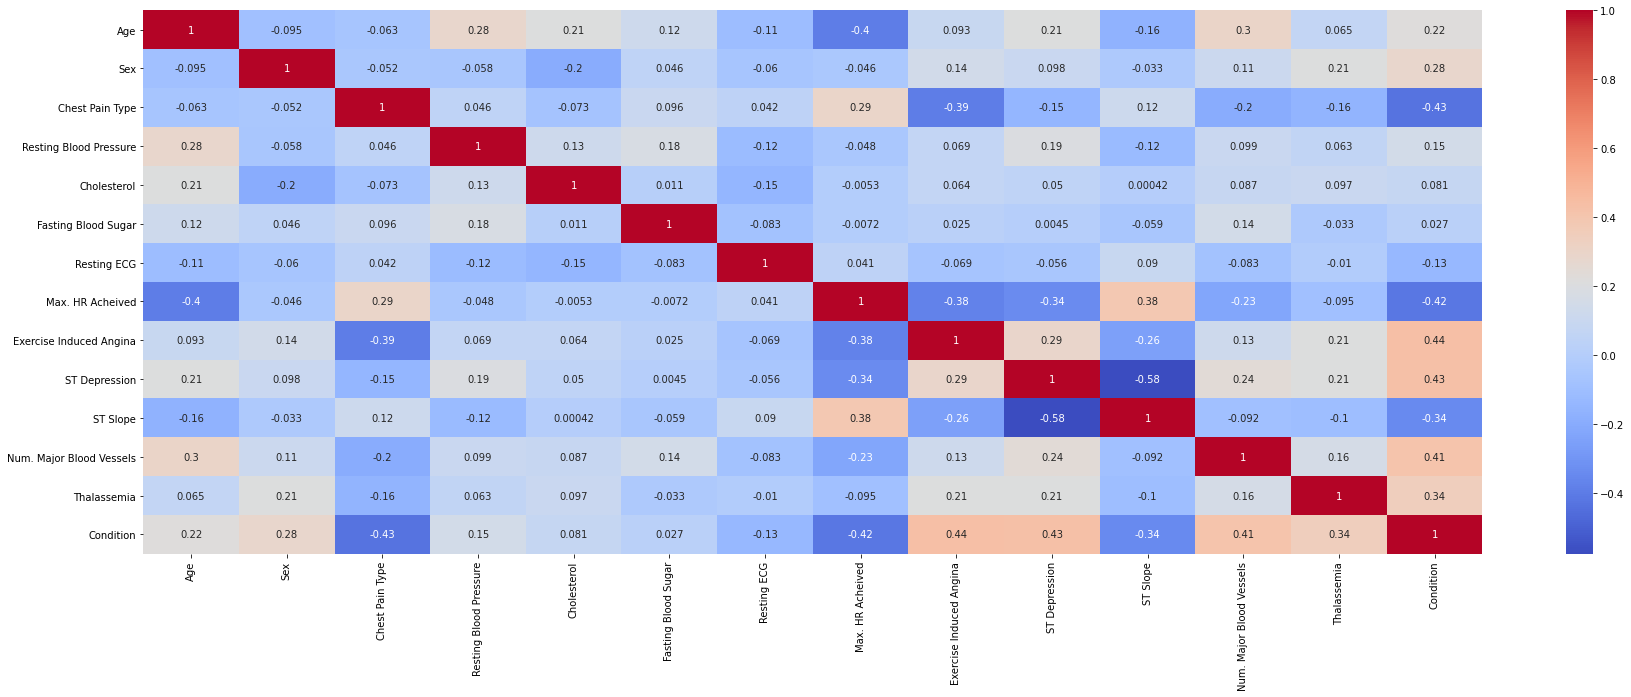

In [11]:
#collinearità
import seaborn as sb
import matplotlib.pyplot as plt
corr = data.corr()
C=abs(corr["Condition"]).sort_values(ascending=False)[1:]
print(C)
plt.figure(figsize=(30,10))
sb.heatmap(corr, cmap='coolwarm', annot = True)


Le variabili non sono fortemente correlate tra di loro quindi non è necessario eliminarne alcuna

<AxesSubplot:>

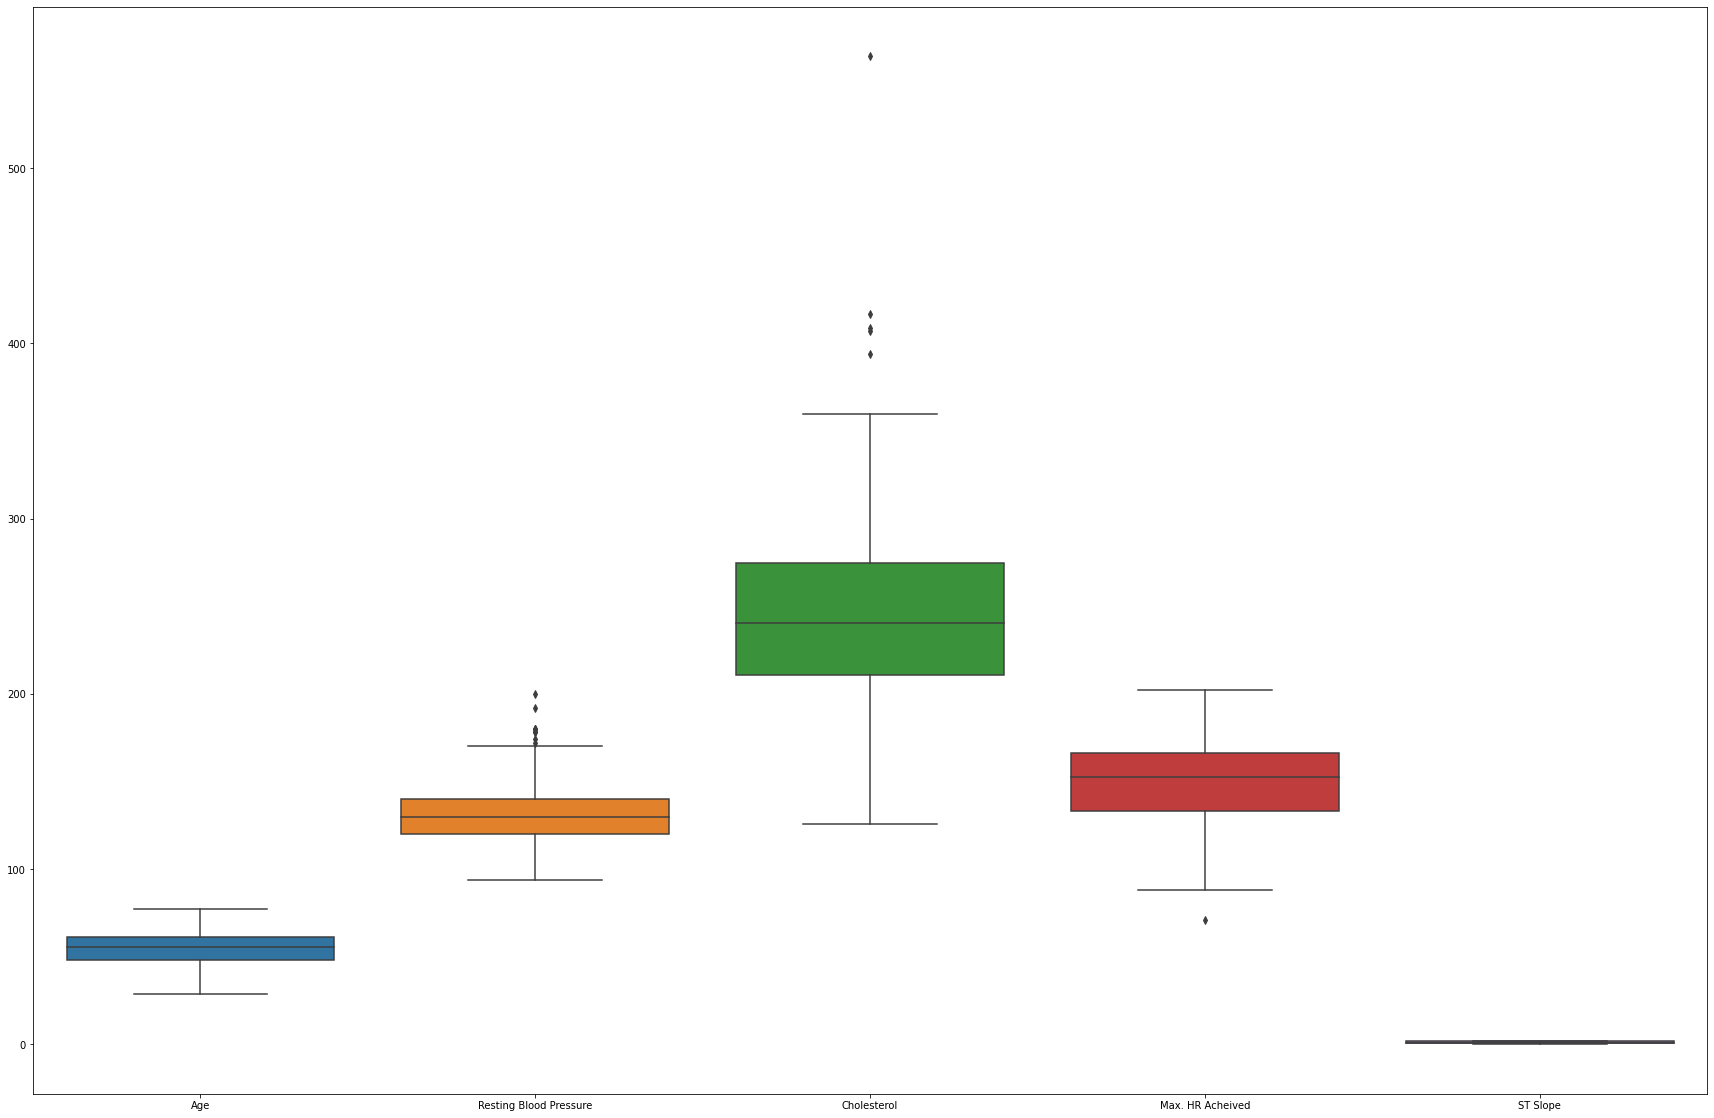

In [9]:
#outliers
cont_variables = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Max. HR Acheived', 'ST Slope']
plt.figure(figsize=(30,20))
sb.boxplot(data=data[cont_variables])

Non vi è un numero significativo di outliers e dunque non è necessario rimuoverli

### sviluppo modelli blak box

SPLIT del dataset in partizione di training e testing, operazione necessaria per la creazione di un modello di ML supervisionato, dataset di training: 80%, dataset di testing: 20%.

In [8]:
from sklearn.model_selection import train_test_split
y = data['Condition']
X = X = data[['Age', 'Sex', 'Chest Pain Type', 'Resting Blood Pressure',
       'Cholesterol', 'Fasting Blood Sugar', 'Resting ECG', 'Max. HR Acheived',
       'Exercise Induced Angina', 'ST Depression', 'ST Slope',
       'Num. Major Blood Vessels', 'Thalassemia']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(242, 13) (61, 13) (242,) (61,)


### Random Forest

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

n_estimators =[int(x) for x in np.linspace(start = 50, stop = 200, num =7)]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

rf = RandomForestClassifier()

grid_rf = GridSearchCV(estimator = rf, param_grid=param_grid, cv=3)

%time grid_rf_result = grid_rf.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_rf_result.best_score_, grid_rf_result.best_params_))
means = grid_rf_result.cv_results_['mean_test_score']
stds = grid_rf_result.cv_results_['std_test_score']
params = grid_rf_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Wall time: 18.4 s
Best: 0.829835 using {'bootstrap': True, 'max_features': 2, 'n_estimators': 200}
0.813272 (0.020442) with: {'bootstrap': True, 'max_features': 2, 'n_estimators': 50}
0.821502 (0.024057) with: {'bootstrap': True, 'max_features': 2, 'n_estimators': 75}
0.805041 (0.010548) with: {'bootstrap': True, 'max_features': 2, 'n_estimators': 100}
0.817438 (0.015421) with: {'bootstrap': True, 'max_features': 2, 'n_estimators': 125}
0.805041 (0.014678) with: {'bootstrap': True, 'max_features': 2, 'n_estimators': 150}
0.800720 (0.035875) with: {'bootstrap': True, 'max_features': 2, 'n_estimators': 175}
0.829835 (0.012285) with: {'bootstrap': True, 'max_features': 2, 'n_estimators': 200}
0.809156 (0.020953) with: {'bootstrap': True, 'max_features': 3, 'n_estimators': 50}
0.821553 (0.046099) with: {'bootstrap': True, 'max_features': 3, 'n_estimators': 75}
0.800823 (0.001164) with: {'bootstrap': True, 'max_features': 3, 'n_estimators': 100}
0.813323 (0.009217) with: {'bootstrap': True,

In [17]:
#results on the test set for the best model
best_model_rf = grid_rf.best_estimator_
y_pred = best_model_rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
rf_acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc*100,'\n')
print(classification_report(y_test, y_pred))


Confusion Matrix
[[27  5]
 [ 3 26]]


Accuracy of Random Forest: 86.88524590163934 

              precision    recall  f1-score   support

           0       0.90      0.84      0.87        32
           1       0.84      0.90      0.87        29

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



<AxesSubplot:xlabel='features', ylabel='importance_score'>

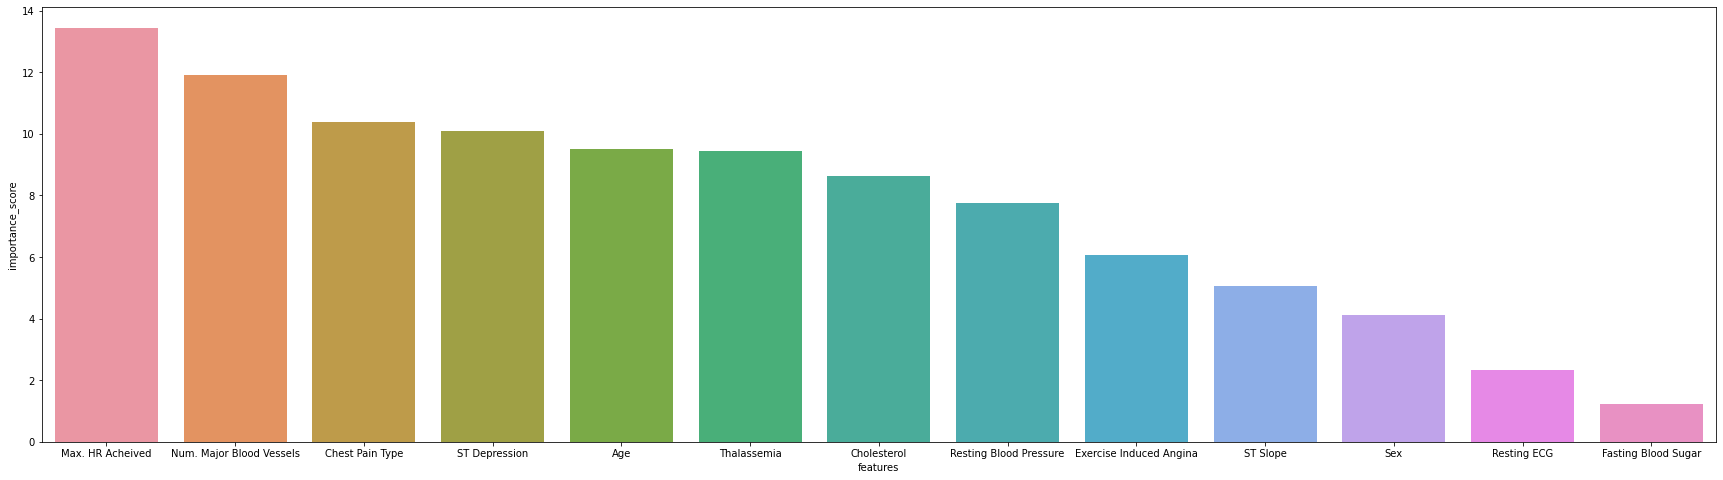

In [13]:
#feature_importance_using_random_forest_model
importances = best_model_rf.feature_importances_*100
feature_list = X_train.columns
sample_df = pd.DataFrame([])
sample_df['features'] = feature_list
sample_df['importance_score'] = importances
sample_df = sample_df.sort_values(by = ['importance_score'],ascending=False)
plt.figure(figsize=(30,8))
sb.barplot(x='features',y='importance_score',data =sample_df)

### Adaboost

In [14]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators =[int(x) for x in np.linspace(start = 50, stop = 200, num =7)]
learning_rate =[float(x) for x in np.linspace(start = 0.01, stop = 1, num =10)]

param_grid = {'n_estimators':n_estimators,
             'learning_rate':learning_rate}

ada=AdaBoostClassifier()

grid_ada = GridSearchCV(estimator = ada, param_grid=param_grid, cv=3)

%time grid_ada_result = grid_ada.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_ada_result.best_score_, grid_ada_result.best_params_))
means = grid_ada_result.cv_results_['mean_test_score']
stds = grid_ada_result.cv_results_['std_test_score']
params = grid_ada_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Wall time: 35.3 s
Best: 0.809156 using {'learning_rate': 0.01, 'n_estimators': 175}
0.771656 (0.033552) with: {'learning_rate': 0.01, 'n_estimators': 50}
0.788323 (0.047005) with: {'learning_rate': 0.01, 'n_estimators': 75}
0.796656 (0.035957) with: {'learning_rate': 0.01, 'n_estimators': 100}
0.800823 (0.040841) with: {'learning_rate': 0.01, 'n_estimators': 125}
0.800823 (0.040841) with: {'learning_rate': 0.01, 'n_estimators': 150}
0.809156 (0.020953) with: {'learning_rate': 0.01, 'n_estimators': 175}
0.809156 (0.020953) with: {'learning_rate': 0.01, 'n_estimators': 200}
0.800823 (0.010272) with: {'learning_rate': 0.12, 'n_estimators': 50}
0.796605 (0.016431) with: {'learning_rate': 0.12, 'n_estimators': 75}
0.796605 (0.016431) with: {'learning_rate': 0.12, 'n_estimators': 100}
0.779887 (0.036766) with: {'learning_rate': 0.12, 'n_estimators': 125}
0.784105 (0.022307) with: {'learning_rate': 0.12, 'n_estimators': 150}
0.788272 (0.021364) with: {'learning_rate': 0.12, 'n_estimators': 17

In [15]:
#results on the test set for the best model
best_model_ada = grid_ada.best_estimator_
y_pred = best_model_ada.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
ada_acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(conf_matrix)
print("\n")
print("Accuracy of Adaboost:",ada_acc*100,'\n')
print(classification_report(y_test, y_pred))

Confusion Matrix
[[28  4]
 [ 5 24]]


Accuracy of Adaboost: 85.24590163934425 

              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.86      0.83      0.84        29

    accuracy                           0.85        61
   macro avg       0.85      0.85      0.85        61
weighted avg       0.85      0.85      0.85        61



<AxesSubplot:xlabel='features', ylabel='importance_score'>

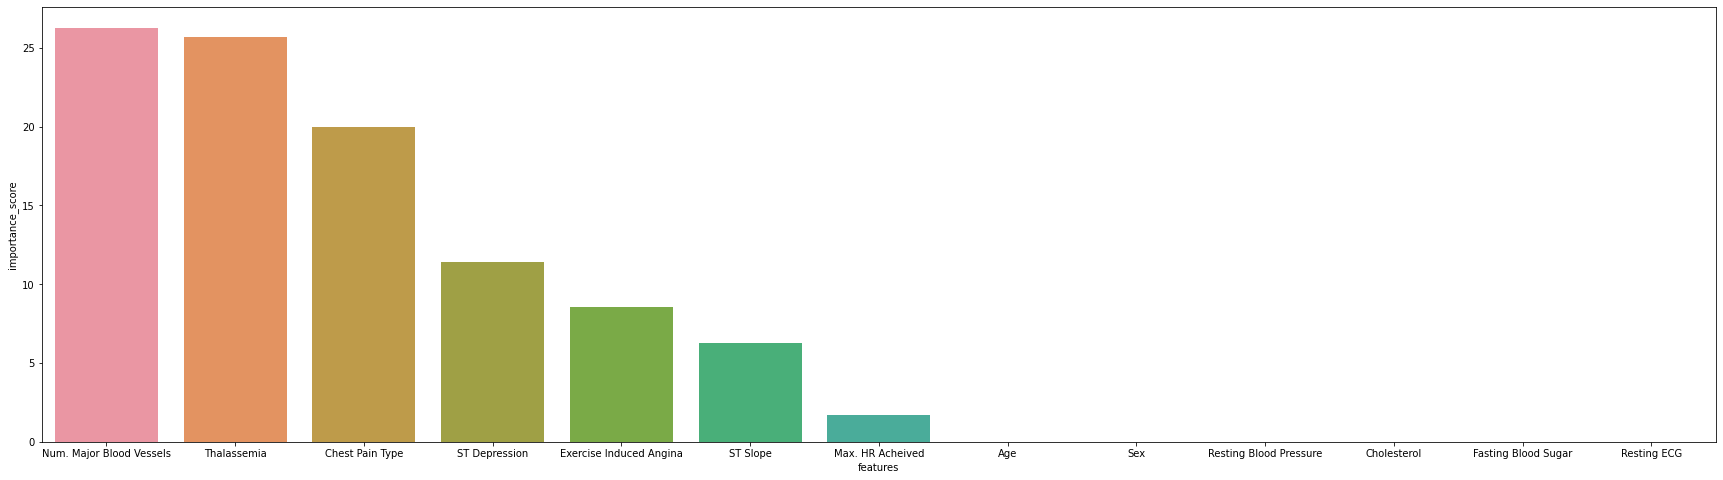

In [16]:

importances = best_model_ada.feature_importances_*100
feature_list = X_train.columns
sample_df = pd.DataFrame([])
sample_df['features'] = feature_list
sample_df['importance_score'] = importances
sample_df = sample_df.sort_values(by = ['importance_score'],ascending=False)
plt.figure(figsize=(30,8))
sb.barplot(x='features',y='importance_score',data =sample_df)

### Gradien Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
n_estimators =[int(x) for x in np.linspace(start = 50, stop = 200, num =7)]
learning_rate =[0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
max_features = [2, 3, 4]
max_depth= [2, 3, 4]


param_grid = {'n_estimators':n_estimators,
             'learning_rate':learning_rate,
             'max_features':max_features,
             'max_depth':max_depth}

gb=GradientBoostingClassifier()

grid_gb = GridSearchCV(estimator = gb, param_grid=param_grid, cv=3)

%time grid_gb_result = grid_gb.fit(X_train,y_train)

# summarize results
print("Best: %f using %s" % (grid_gb_result.best_score_, grid_gb_result.best_params_))
means = grid_gb_result.cv_results_['mean_test_score']
stds = grid_gb_result.cv_results_['std_test_score']
params = grid_gb_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Wall time: 1min 30s
Best: 0.838169 using {'learning_rate': 0.075, 'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
0.817387 (0.021551) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 2, 'n_estimators': 50}
0.825720 (0.010257) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 2, 'n_estimators': 75}
0.821605 (0.011279) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 2, 'n_estimators': 100}
0.825669 (0.011035) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 2, 'n_estimators': 125}
0.829733 (0.024370) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 2, 'n_estimators': 150}
0.821553 (0.015814) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 2, 'n_estimators': 175}
0.838066 (0.018478) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 2, 'n_estimators': 200}
0.829887 (0.015430) with: {'learning_rate': 0.05, 'max_depth': 2, 'max_features': 3, 'n_estimators': 50}
0.821553 (0.006462) with: {'learni

In [18]:
#results on the test set for the best model
best_model_gb = grid_gb.best_estimator_
y_pred = best_model_gb.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
gb_acc = accuracy_score(y_test, y_pred)
print('Confusion Matrix')
print(conf_matrix)
print("\n")
print("Accuracy of Gradient Boosting:",gb_acc*100,'\n')
print(classification_report(y_test, y_pred))

Confusion Matrix
[[29  3]
 [ 4 25]]


Accuracy of Gradient Boosting: 88.52459016393442 

              precision    recall  f1-score   support

           0       0.88      0.91      0.89        32
           1       0.89      0.86      0.88        29

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



<AxesSubplot:xlabel='features', ylabel='importance_score'>

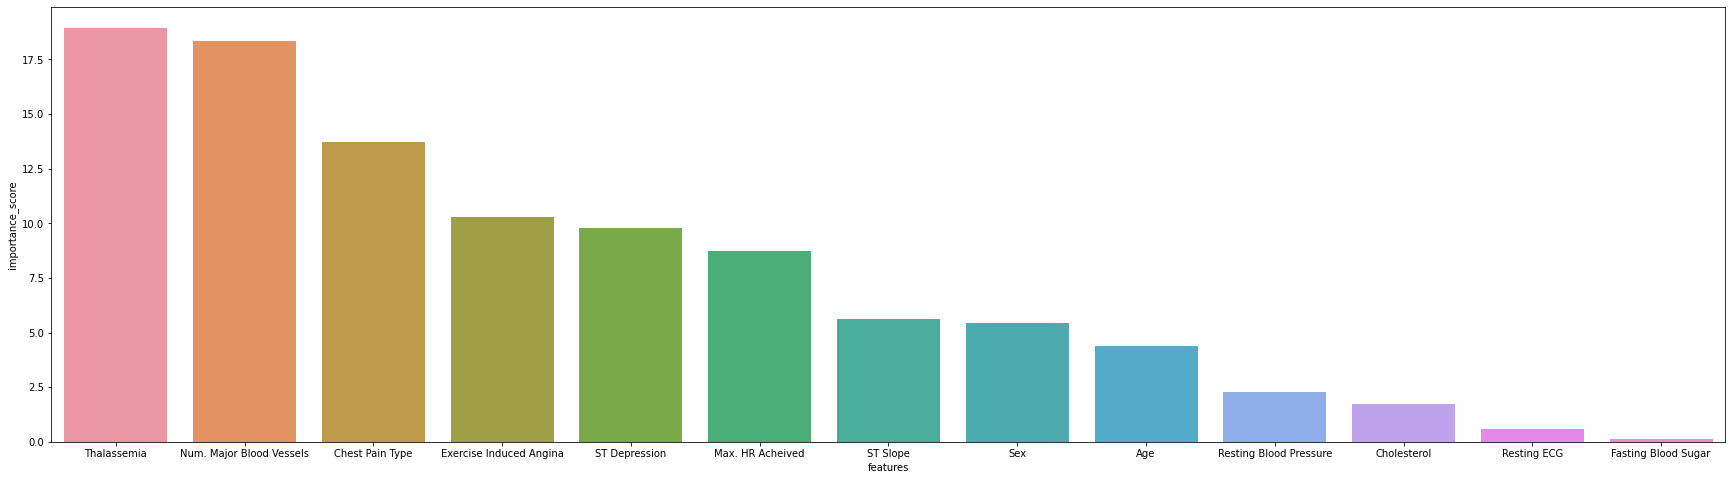

In [20]:

importances = best_model_gb.feature_importances_*100
feature_list = X_train.columns
sample_df = pd.DataFrame([])
sample_df['features'] = feature_list
sample_df['importance_score'] = importances
sample_df = sample_df.sort_values(by = ['importance_score'],ascending=False)
plt.figure(figsize=(30,8))
sb.barplot(x='features',y='importance_score',data =sample_df)

Il modello vincente tra quelli presi in considerazione è il Gradient Boosting i cui parametri tunati risultano essere:  numero di estimatori (50), il learning_rate (0.075) per determinare la velocità di apprendimento, max depth (2) la quale determina la profondità dell'albero e max features (2) ovvero il numero di features da considerare quando si vuole effettuare il migliore split.
Notiamo che per il Gradient Boosting le variabili più importanti nella construzione degli alberi, ovvero le varibili che sono state utilizzate più spesso per splittare le osservazioni nel miglior modo, sono: in primis 'Thalassemia' e 'Num. Major Blood Vessels' seguite da 'Chest Pain Type' e 'Exercise Induced Angina'.
-Thalassemia: malattia genetica ereditaria che provoca una malformazione nella struttura dei globuli rossi
-Num Major blood Vessels: il numero di vasi sangunei colorati da 'Fluoroscopy' è un test in grado di dirci se una persona è a rischio di malattie cardiache o meno. Più il numero di vasi sangunei colorati da questo test è alto, maggiore sarà il rischio.
-Chest Pain Type: tipo di dolore toracico. Nonostante questa variabile risulti essere importante nel nostro modello, nella realtà è molto ambiguia poichè il tipo di dolore rilevato dai pazienti è molto soggettivo.
-Exercise Induced Angina: stabilisce se l'esercizio fisico induce a dolori al torace


### Save Models

In [36]:
import pickle
Pkl_Filename = "rf.pkl" 
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model_rf, file)

In [37]:
Pkl_Filename = "ab.pkl" 
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model_ada, file)

In [38]:
Pkl_Filename = "gb.pkl" 
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model_gb, file)

### Upload GB

In [1]:
import pickle
Pkl_Filename = "gb.pkl" 
with open(Pkl_Filename, 'rb') as file:  
    gb = pickle.load(file)
gb

GradientBoostingClassifier(learning_rate=0.075, max_depth=2, max_features=2,
                           n_estimators=50)

### SHAP

SHAP è un explainer globale che usa combinazioni delle singole istanze per spiegare come un modello black box (come il gradeint boosting) arriva a classificare le istanze del dataset considerato.

In [10]:
import shap
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_test)

stampo il contributo di ogni feature per predirre la 24-esima osservazione

In [11]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[5,:], 
                X_test.iloc[5,:], link="logit")

In [20]:
y_test[5]

0

Grazie a SHAP è intuibile spiegare come, ad esempio, l'algoritmo Gradient Boosting ha classificato la 24-esima istanza. Con una probabilità pari al 16% di avere un infarto, il soggetto preso in considerazione non ha vasi sanguinei colorati dal test 'fluroscopu meaning', ha un tasso di thalassemia normale (=2) e il tipo di tolore toracico NON anginoso (tipico di pazienti che non hanno malattie al cuore).

#### Shap Values summary plot

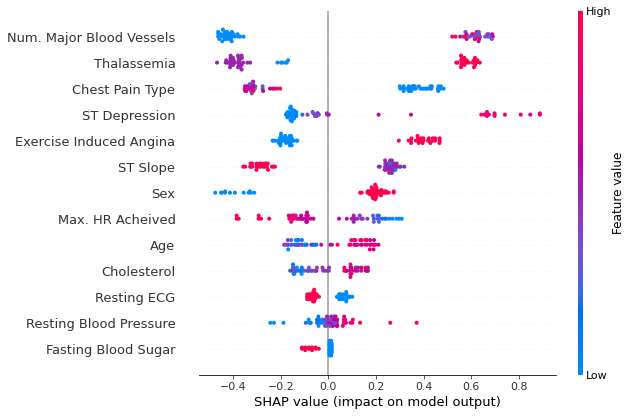

In [50]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

Grazie a questo summary plot, possiamo comprendere quali variabili pesano maggiormente sulla probabilità di essere un paziente a rischio di infarto o viceversa. Ad esempio, avere un numero di vasi sangunei colorati dal test 'Fluroscopy' maggiore a aumenta la probabilità di successo di almeno 0.4 punti percentuali. Oppure, essere maschio o percepire dolori al torace dopo aver fatto attività fisica aumenta la probabilità di successo di 0.15 e 0.25 rispettivamente. 
Al contrario, essere femmina diminuisce la probabilità di essere a rischio di infarto di 0.25 punti percentuali.

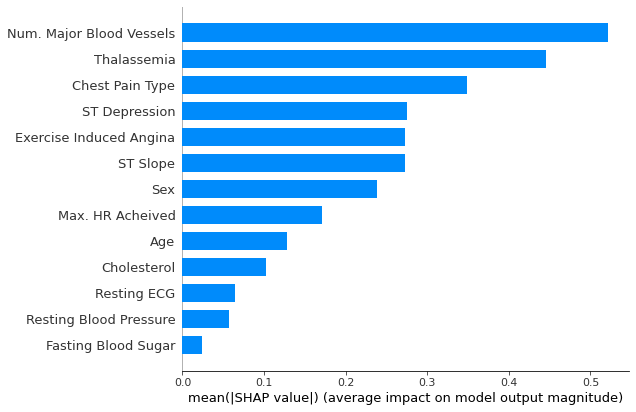

In [31]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Ora esploriamo l'interazione tra due variabili che, nonostante non risultino essere di particolare importanza nel nostro modello, sono entrambe continue e di semplice interpretazione in quanto sono note a tutti: l'età e il colesterolo.

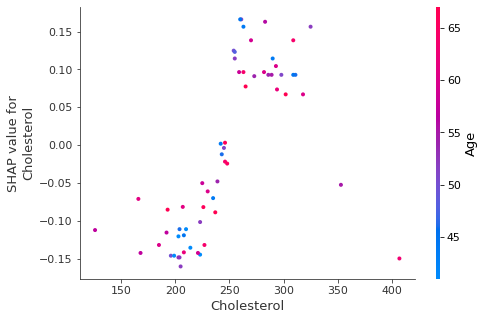

In [48]:
shap.dependence_plot('Cholesterol', shap_values, X_test, 
                     interaction_index="Age")

Notiamo che più il livello del colesterolo è alto, più i SHAP values sono alti e dunque più probabile che un paziente sia a rischio di infarto. Inoltre, grazie al colore dei punti riportati nel grafico che indicano l'età dei soggetti, notiamo che tendenzialmente i pazienti più vecchi sono anche quei pazienti con un livello di colesterolo più alto (anche se questa differenza non è molto marcata, infatti ci sono molti soggetti anziani con un tasso di colesterolo basso).



Fino ad ora siamo riusciti, grazie a SHAP e all'importanza delle variabili del Gradient Bosting, a capire quali features sono più rilevanti e utilizzate dal modello black box per discriminare le istanze considerate. Tuttavia, siamo interessati a ricavare delle regole tramite cui l'algoritmo arriva a predere delle decisioni. Questo è possibile sviluppando un modello surrogato (albero).

### Decision Tree Classifier

Uno degli esempi più facili e diffusi per l’utilizzo di un modello glass box con un output più comprensibile e semplice da interpretare è l'albero. E' per questo motivo che, per comprendere meglio le regole classificative a cui ha fatto fede il gradient boosting, ho deciso di adottare questo modello decisionale.  Creo ora il modello glass box tunando il criterio di split, la profondità e il numero massimo di istanze per split.

Per prima cosa definiamo la nuova colonna target, ovvero le y_predicted del gradient boosting.

In [15]:
new_target = gb.predict(X_train)

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

max_depth =[5, 6, 7, 8, 9, 10]

max_features = [3, 6, 9, 12, 13]

min_sample_split = [2, 5, 10, 15, 20]

param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth':max_depth,
             'max_features':max_features,
             'min_samples_split':min_sample_split}

dt=DecisionTreeClassifier()

grid_dt = GridSearchCV(estimator = dt, param_grid=param_grid, cv=3)

%time grid_dt_result = grid_dt.fit(X_train,new_target)

# summarize results
print("Best: %f using %s" % (grid_dt_result.best_score_, grid_dt_result.best_params_))

Wall time: 2.79 s
Best: 0.908591 using {'criterion': 'entropy', 'max_depth': 6, 'max_features': 12, 'min_samples_split': 20}


In [21]:
gb_pred = gb.predict(X_test)
best_model_dt = grid_dt.best_estimator_
surrogate_pred = best_model_dt.predict(X_test)
conf_matrix = confusion_matrix(gb_pred, surrogate_pred)
gb_acc = accuracy_score(gb_pred, surrogate_pred)
print('Confusion Matrix')
print(conf_matrix)
print("\n")
print("Accuracy of decision tree:",gb_acc*100,'\n')
print(classification_report(gb_pred, surrogate_pred))


Confusion Matrix
[[30  1]
 [ 3 27]]


Accuracy of decision tree: 93.44262295081968 

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        31
           1       0.96      0.90      0.93        30

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61



Notiamo come il modello migliore risulta avere profondità pari a 6, come criterio per la purezza dei nodi l'entropia e numero di feature considerate ad ogni split pari a 12. Il modello risulta avere ottime performance con accurancy pari al 93%.
Per avere un explaination globale effettuiamo ora uno step di data visualization, in cui prenderemo visione del modello surrogato:

In [24]:
import dill
dill.dump_session('notebook_heart.db')

In [30]:
Pkl_Filename = "dt.pkl" 
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model_dt, file)

In [32]:
import pickle
Pkl_Filename = "dt.pkl" 
with open(Pkl_Filename, 'rb') as file:  
    dt = pickle.load(file)
dt

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features=12,
                       min_samples_split=20)

In [34]:
from sklearn.tree import export_graphviz
feature_names = X.columns

dotfile = open("tree1.dot", 'w')
export_graphviz(dt,
                proportion=True,
                out_file = dotfile,
                feature_names=feature_names,
                class_names=['no risk', 'risk'],
                filled=True,
                rounded=True,
                max_depth=10)
dotfile.close()

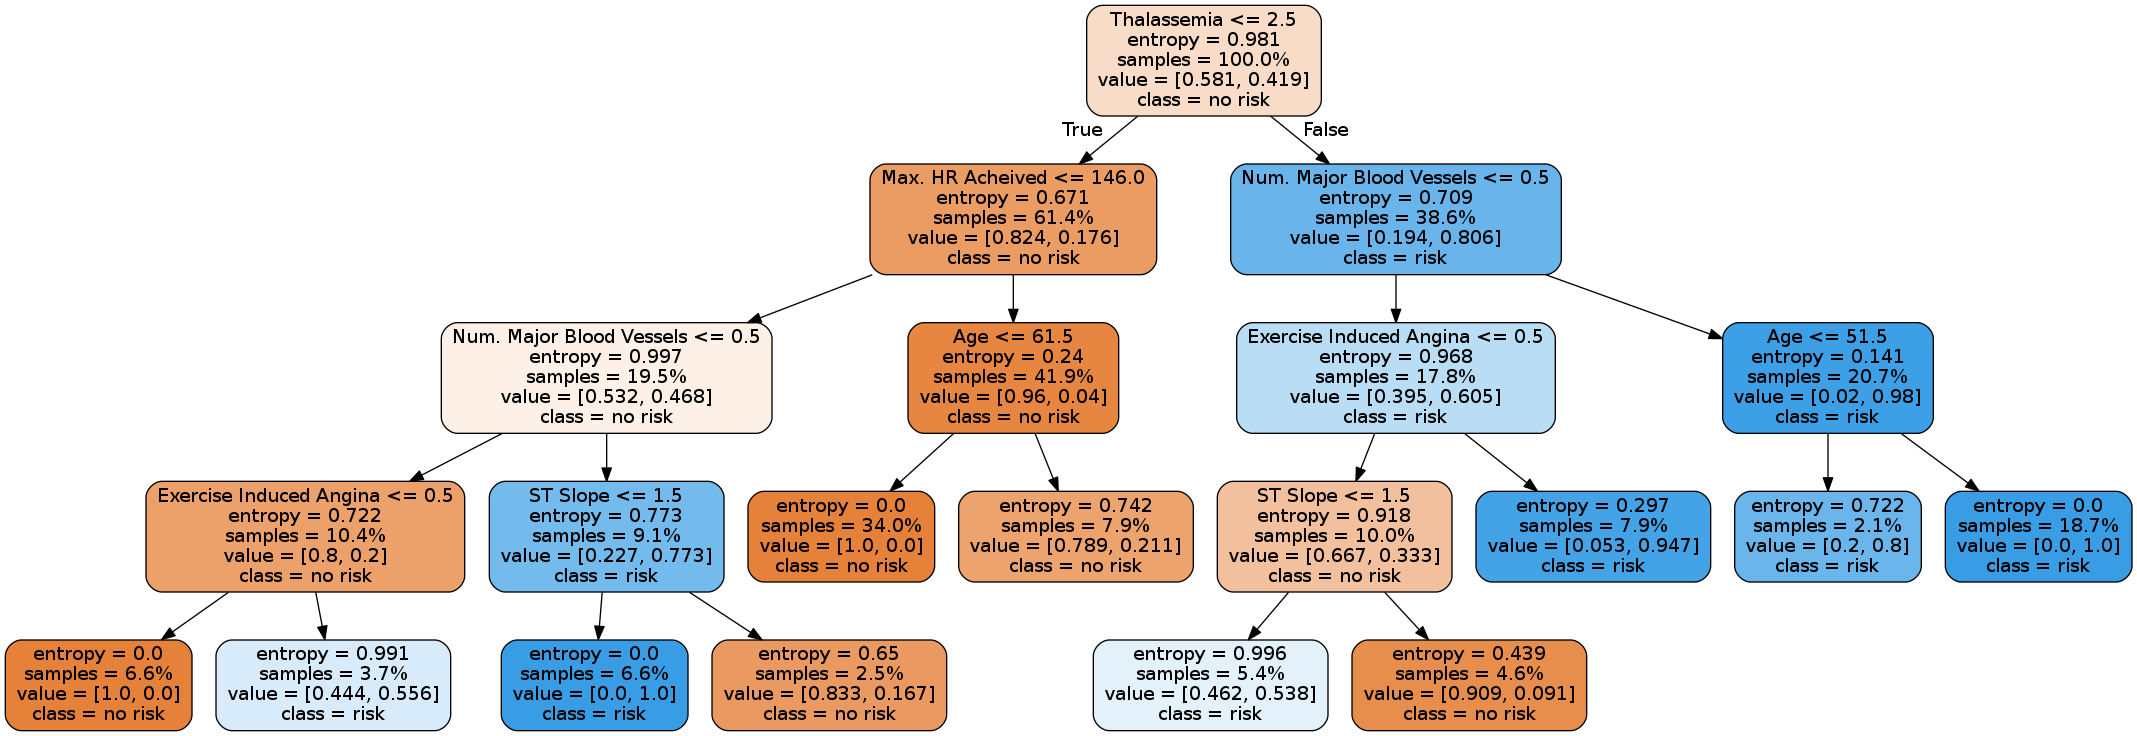

In [35]:
from IPython.core.display import Image, display
display(Image('tree1.png', unconfined=True))

Da questa figura possiamo ricavare delle regole che ci aiutano a comprendere come l'algoritmo Gradient Boosting classifica le istanze.Di seguito ne vengono riportate alcune:

**IF** il difetto della THALASSEMIA sui globuli rossi è normale o fissato (thalassemia <= 2.5)   **AND**  il massimo battito cardiaco raggiunto sotto test è MINORE O UGUALE di 146 (Max. HR achived <= 146)  **AND** il numero di vasi sangunei colorati da apposito test è UGUALE a 0 (Num. Major Blood Vessels <= 0.5)**AND** l'eserciszio fisico non induce a dolori al torace (Exercise Induced Angina <= 0.5) **THEN** il paziente non è a rischio di infarto (entropia = 0)

**IF** il difetto della THALASSEMIA sui globuli rossi è normale o fissato (thalassemia <= 2.5)   **AND**  il massimo battito cardiaco raggiunto sotto test è MAGGIORE di 146 (Max. HR achived > 146) **AND** età del paziente è MINORE   di 62 (age <= 61.5) **THEN** il paziente non è a rischio di infarto (entropia = 0)

**IF** il difetto della THALASSEMIA sui globuli rossi è reversibile (thalassemia = 3)   **AND** il numero di vasi sangunei colorati da apposito test è MAGGIORE di 0 (Num. Major Blood Vessels > 0.5) **AND** età del paziente è MAGGIORE   di 51 (age > 51.5) **THEN** il paziente è a rischio di infarto (entropia = 0)

**IF** il difetto della THALASSEMIA sui globuli rossi è reversibile (thalassemia = 3)   **AND** il numero di vasi sangunei colorati da apposito test è UGUALE a 0 (Num. Major Blood Vessels <= 0.5) **AND** l'eserciszio fisico induce a dolori al torace (Exercise Induced Angina > 0.5) **THEN** il paziente è a rischio di infarto (entropia = 0.297)
